## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_horizontal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


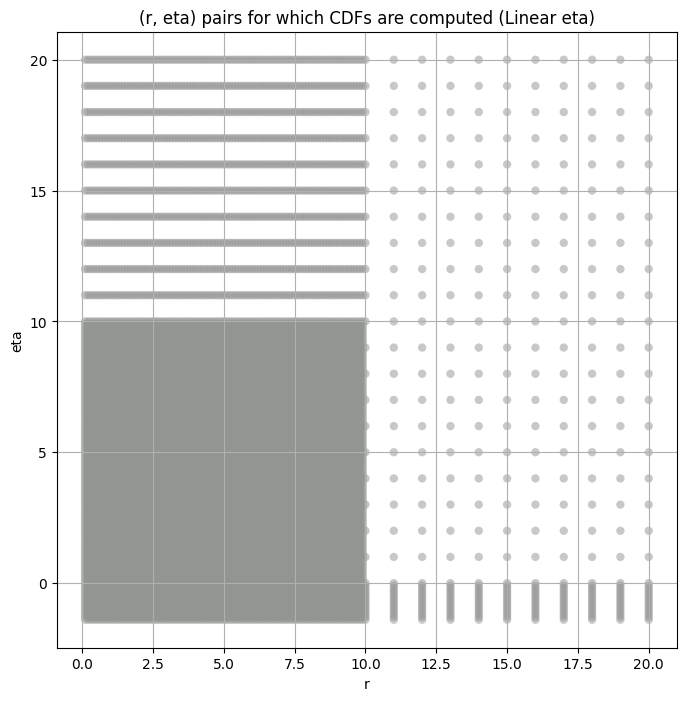

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.478996e+07  2.233421e+07  2.733704e+07   0.435762    0.032408   
3      5.422982e+06  5.098264e+06  5.754792e+06   1.545989    1.198762   
4      1.175513e+06  1.104955e+06  1.248217e+06   3.541689    2.922917   
5      2.200822e+05  2.051823e+05  2.355847e+05   5.292702    4.484963   
6      3.989627e+04  3.659656e+04  4.333954e+04   8.906837    7.516291   
7      6.966373e+03  6.281430e+03  7.704541e+03  13.543694   11.132702   
8      1.295555e+03  1.142669e+03  1.463124e+03  20.680162   16.469147   
9      2.740761e+02  2.375567e+02  3.139993e+02  27.580788   21.251253   

       kurt_upper  total_samples  
layer                             
2        0.899321           1604  
3        1.921160           6416  
4        4.230144          25664  
5        6.221855         102656  
6       10.530184         410624  
7       16.415705        1642496  
8       25.764788        6569984  
9       36.107666       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      2.478996e+07   2.478996e+07    1.990542e+07    1.717958e+07   
3      5.422982e+06   5.422982e+06    4.887914e+06    4.548298e+06   
4      1.175513e+06   1.175513e+06    1.115065e+06    1.074329e+06   
5      2.200822e+05   2.200822e+05    2.156649e+05    2.123734e+05   
6      3.989627e+04   3.989627e+04    3.881539e+04    3.799736e+04   
7      6.966373e+03   6.966374e+03    6.709621e+03    6.519365e+03   
8      1.295555e+03   1.295555e+03    1.230583e+03    1.184183e+03   
9      2.740761e+02   2.740761e+02    2.570652e+02    2.452877e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        1.506161e+07     1.325841e+07     1.024977e+07     7.981283e+06   
3        4.273196e+06     4.036906e+06     3.650826e+06     3.329709e+06   
4        1.041676e+06     1.013273e+06     9.630136e+05     9.203568e+05   
5        2.094864e+05     2.068679e+05     2.021298e+05     1.978523e+05   
6        3.727959e+04     3.662960e+04     3.547939e+04     3.446427e+04   
7        6.356042e+03     6.211692e+03     5.960924e+03     5.745042e+03   
8        1.145241e+03     1.111104e+03     1.052564e+03     1.002901e+03   
9        2.355160e+02     2.270502e+02     2.127408e+02     2.008416e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         6.240527e+06     4.886134e+06     3.814765e+06     1.558656e+06  
3         3.053972e+06     2.812516e+06     2.598733e+06     2.068266e+06  
4         8.821871e+05     8.480944e+05     8.173497e+05     7.376799e+05  
5         1.939095e+05     1.902602e+05     1.868406e+05     1.776616e+05  
6         3.354855e+04     3.270706e+04     3.192522e+04     2.985807e+04  
7         5.552239e+03     5.377084e+03     5.216816e+03     4.802274e+03  
8         9.596044e+02     9.211235e+02     8.864720e+02     7.992205e+02  
9         1.906376e+02     1.817030e+02     1.737581e+02     1.541744e+02

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.10054549638932747 24789962.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.11082078416534141 19905418.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.11832989158228385 17179578.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.12598538594783837 15061606.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.13782216642709189 13258409.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.16641816991935143 10249766.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.1960330069378723 7981283.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.22437918769938914 6240527.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.25052023903618525 4886133.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.27879396538892975 3814765.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.3677418852684442 1558655.8
Number of samples: 1604, Without approximation : 1604


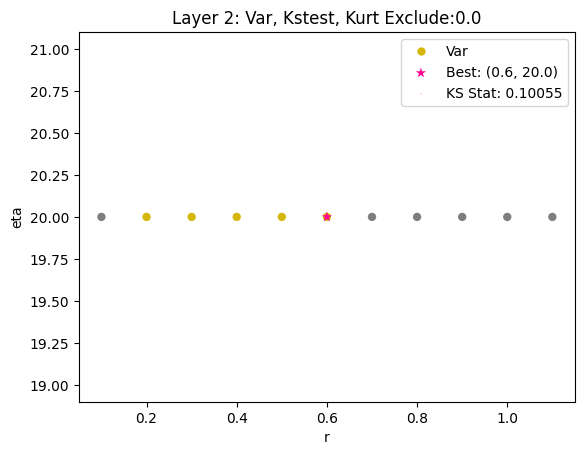

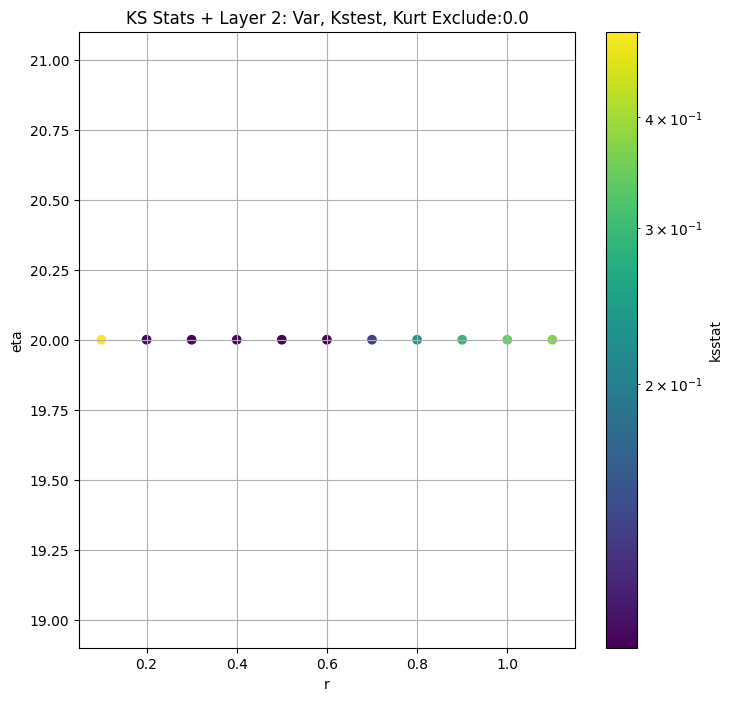

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.059434569822777505 5422982.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.06050911652249813 4887914.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.06104485232431289 4548297.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.06139430102007254 4273196.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.06185308066010903 4036906.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.06248136367945201 3650826.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.06298107044608797 3329709.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.06420581942561798 3053972.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.07232975281305243 2812516.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.08057176050043002 2598733.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.10506941532006508 2068266.0
Number of samples: 6416, Without approximation : 6416


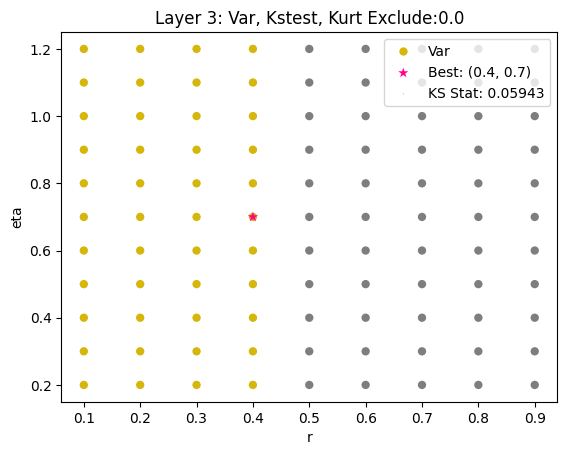

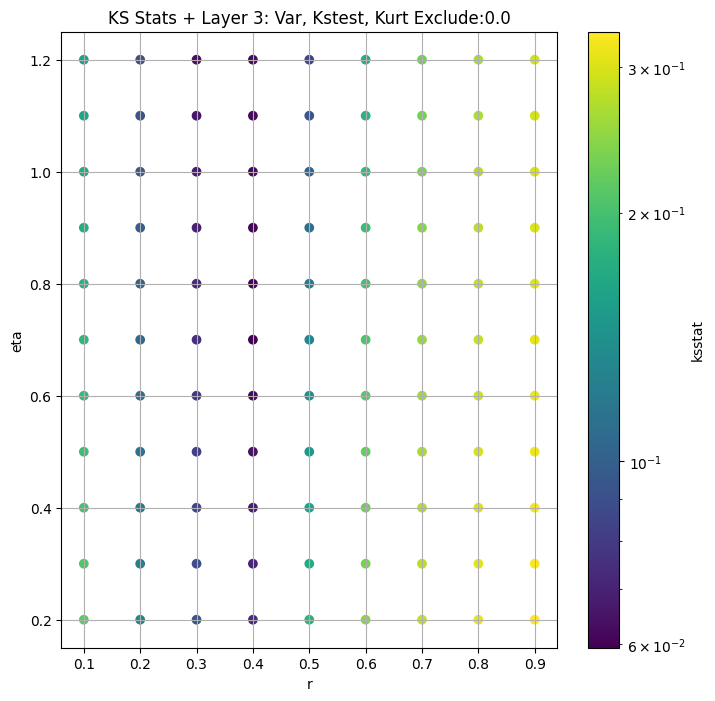

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.04413656950145062 1175513.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.04427796407372764 1115065.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.04427390599068226 1074328.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.04453844366049775 1041675.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.04442387691762156 1013273.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.04490914413598296 963013.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.045748807314230366 920356.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.04570761432133236 882187.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.04662762786758878 848094.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.047350297159659605 817349.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.048698559931413976 737679.9
Number of samples: 25664, Without approximation : 25664


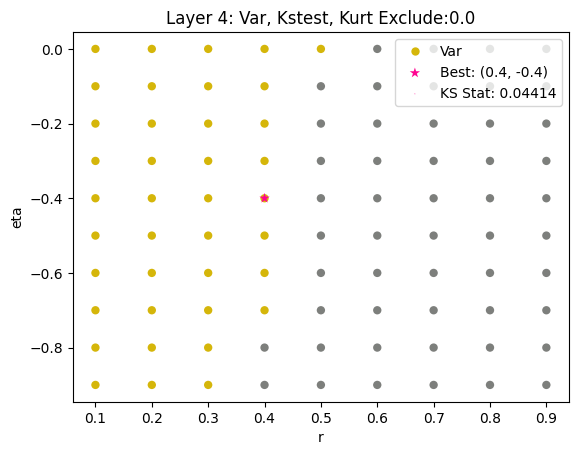

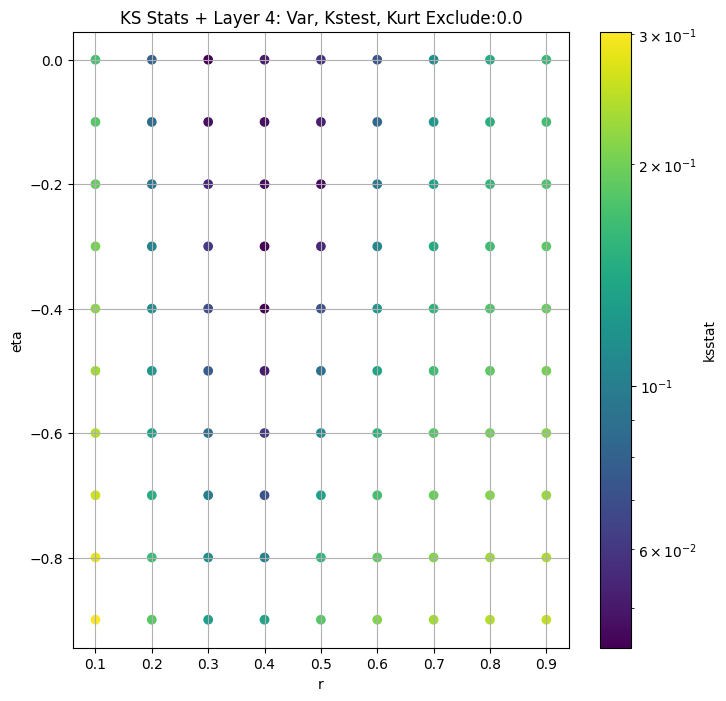

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03437490727107828 220082.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.034824213613125266 215664.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.03490210788295728 212373.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03480331412080229 209486.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.034787766293355005 206867.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03475888527522686 202129.83


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.034731943216200156 197852.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03470634034378606 193909.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03468195211066638 190260.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03465846562663699 186840.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03460343627657869 177661.64
Number of samples: 100000, Without approximation : 102656


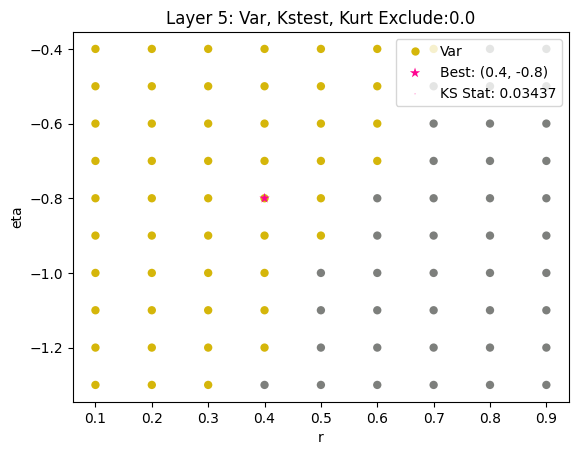

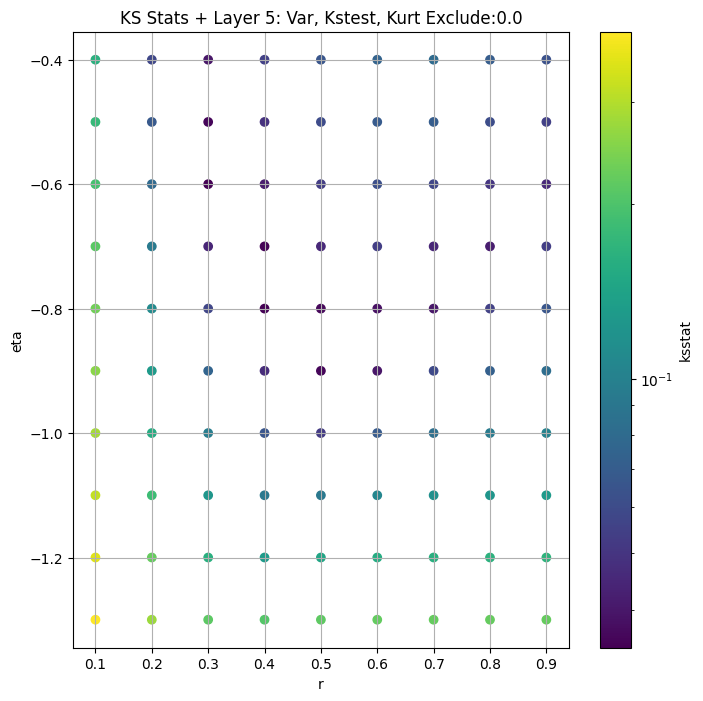

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.0338057789204847 39896.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.0326651750492169 38815.395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.03256927493017303 37997.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.03248402232548403 37279.586


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.03240482227963665 36629.598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.03230010522882987 35479.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.03275584702953993 34464.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.03318278028281252 33548.547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.033441950090608574 32707.064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.033391410205676264 31925.217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.03302392071564131 29858.066
Number of samples: 100000, Without approximation : 410624


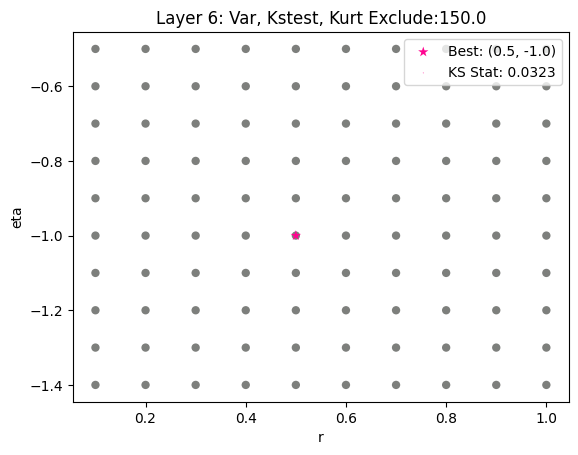

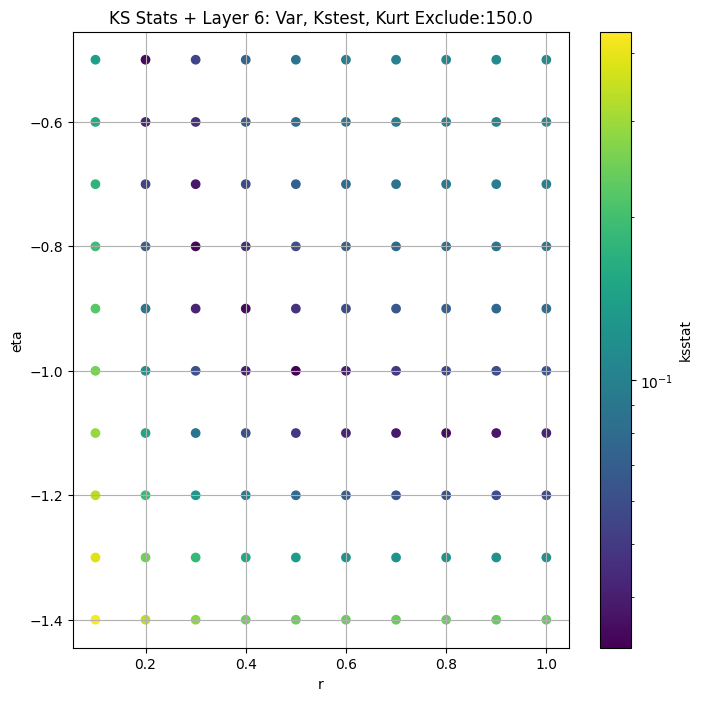

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.03342524292157681 6966.3735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.03146785960107121 6709.621


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.03206015899436221 6519.365


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.0328947041229829 6356.042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.03314529034641475 6211.6924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.03097231651127272 5960.924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.03197393046833685 5745.0415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.03168669437485408 5552.239


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.030880600448559448 5377.084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.031877527430717256 5216.8164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.030398087931095358 4802.274
Number of samples: 100000, Without approximation : 1642496


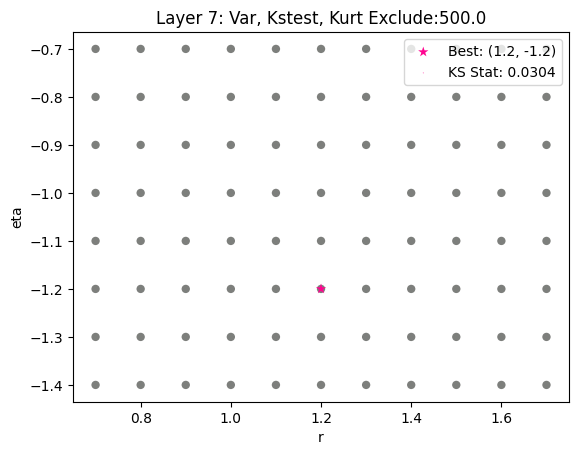

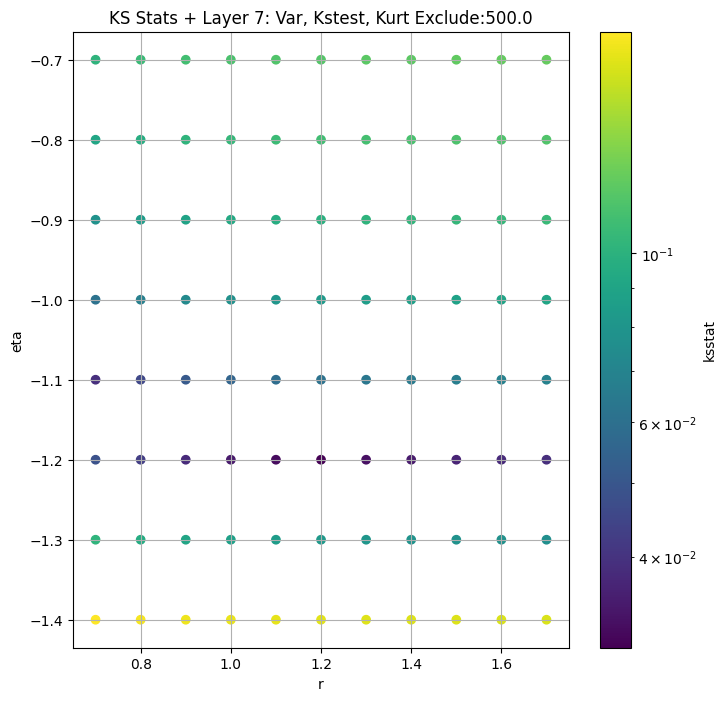

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.017272383805717606 1295.5549


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.01589891310112934 1230.5835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.01694273553913661 1184.1833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0178609832254375 1145.2411


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.018210054326602054 1111.1038


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.01734012851979111 1052.5642


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.016572591420159377 1002.9012


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.015888043765885873 959.6044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.016432084795830915 921.12354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.017632397098104713 886.47205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.015961067161297637 799.2205
Number of samples: 100000, Without approximation : 6569984


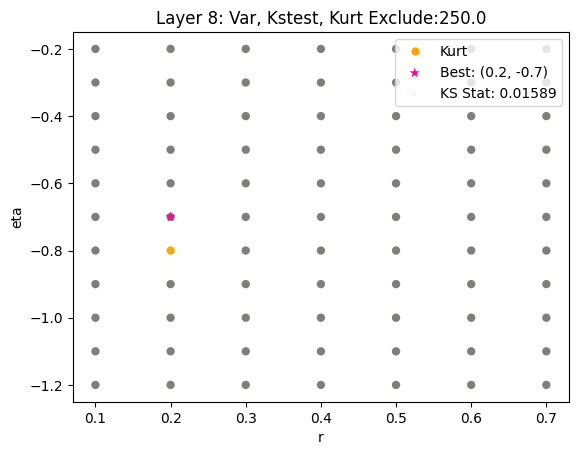

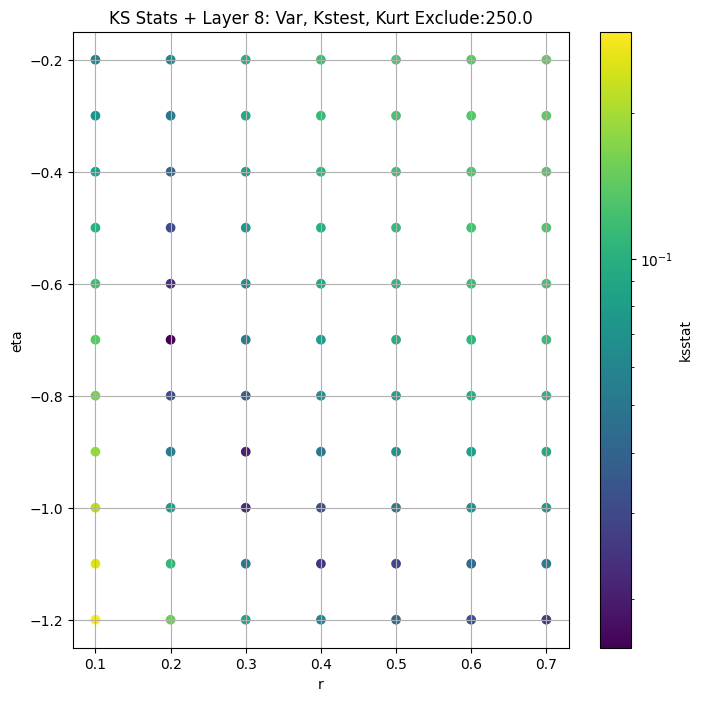

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.01184352720828874 274.07608


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.011390243177207937 257.0652


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.013169156277688665 245.28773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.013717403947918205 235.51598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.014272991414163272 227.05019


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.015410100032996255 212.74078


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.013216208899936188 200.84164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.011428119844235918 190.63759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.011677952145374704 181.70302


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01348823885683026 173.7581


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.015322966909952829 154.17444
Number of samples: 100000, Without approximation : 26279936


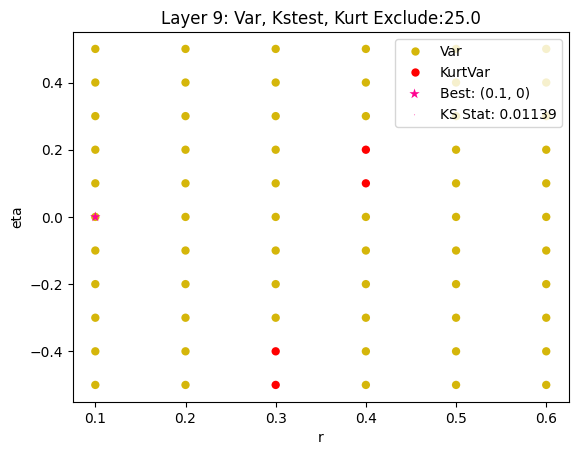

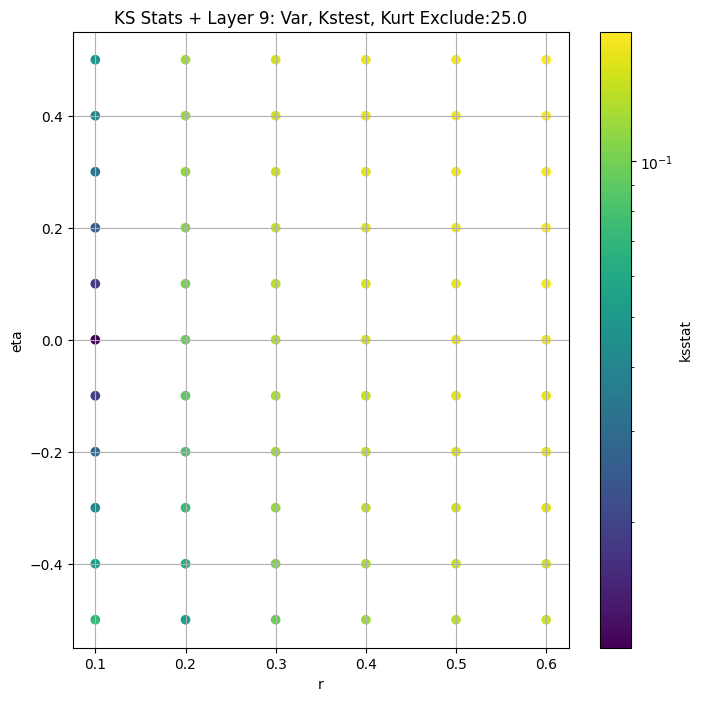

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.478996e+07  2.233421e+07  2.733704e+07   0.435762    0.032408   
3      5.422982e+06  5.098264e+06  5.754792e+06   1.545989    1.198762   
4      1.175513e+06  1.104955e+06  1.248217e+06   3.541689    2.922917   
5      2.200822e+05  2.051823e+05  2.355847e+05   5.292702    4.484963   
6      3.989627e+04  3.659656e+04  4.333954e+04   8.906837    7.516291   
7      6.966373e+03  6.281430e+03  7.704541e+03  13.543694   11.132702   
8      1.295555e+03  1.142669e+03  1.463124e+03  20.680162   16.469147   
9      2.740761e+02  2.375567e+02  3.139993e+02  27.580788   21.251253   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.899321           1604             0.100545        0.6         20.0   
3        1.921160           6416             0.059435        0.4          0.7   
4        4.230144          25664             0.044137        0.4         -0.4   
5        6.221855         102656             0.034375        0.4         -0.8   
6       10.530184         410624             0.032300        0.5         -1.0   
7       16.415705        1642496             0.030398        1.2         -1.2   
8       25.764788        6569984             0.015888        0.2         -0.7   
9       36.107666       26279936             0.011390        0.1          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       6.268102e+04                     0.0        2.478996e+07   
3       5.632023e+04                     0.0        5.422982e+06   
4       5.369387e+04                     0.0        1.175513e+06   
5       2.441367e+04                     0.0        2.200822e+05   
6       1.773970e+04                   150.0        3.547939e+04   
7       1.816908e+04                   500.0        4.802274e+03   
8       1.427983e-01                   250.0        9.596044e+02   
9       3.611985e-11                    25.0        2.570652e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.13782216642709189, var: 13258409.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.1254091467333288, var: 15061606.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.11802114209408349, var: 17179578.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.11060755471954692, var: 19905418.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.10042579320471506, var: 24789962.0
Number of samples: 1604, Without approximation : 1604


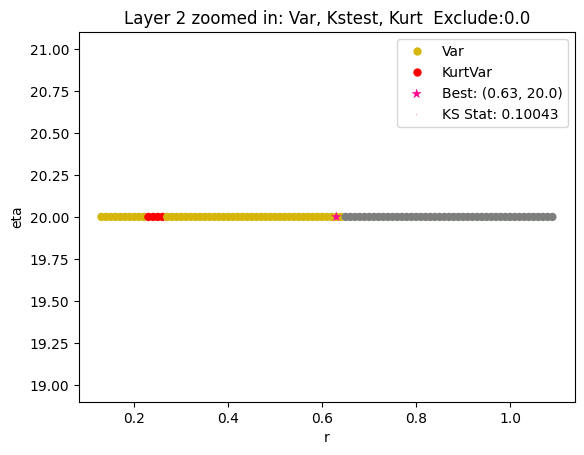

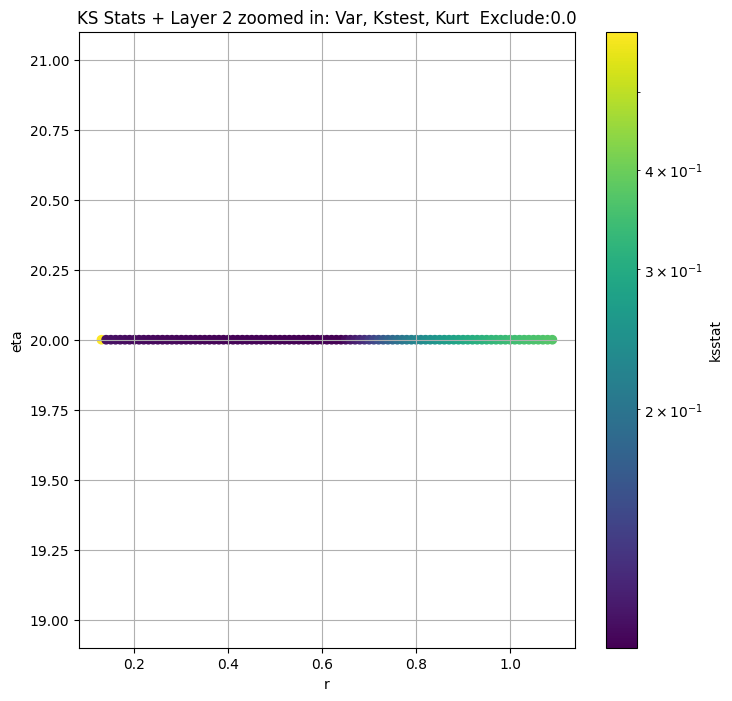

Layer 3


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.07185825584934913, var: 4036906.5


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.0670426582959518, var: 4273196.0


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.060924302922051865, var: 4548297.5


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.060121172611885154, var: 4887914.5


  0%|          | 0/880 [00:00<?, ?it/s]

Finding Minimum after computing 880 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.059423049716101184, var: 5422982.0
Number of samples: 6416, Without approximation : 6416


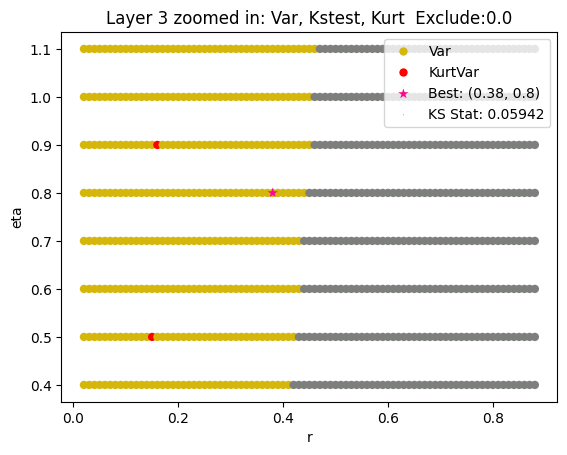

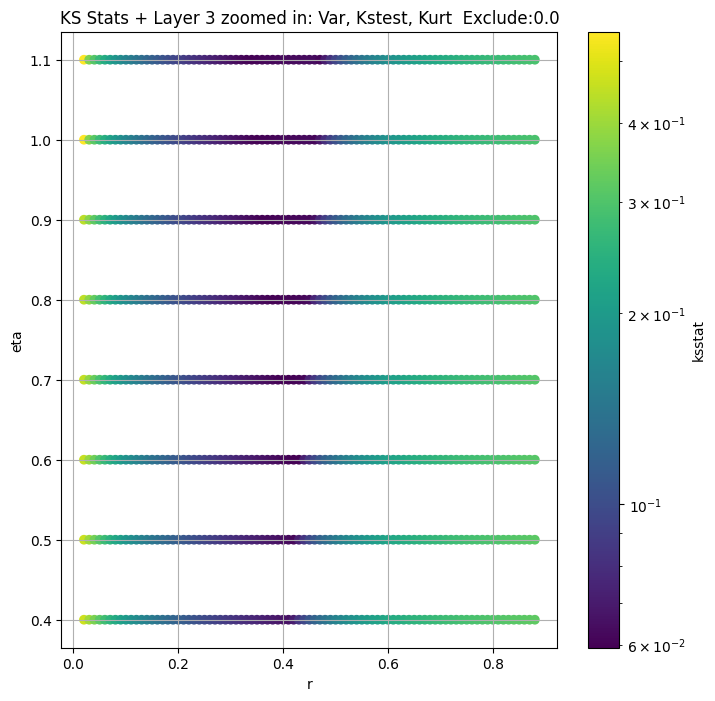

Layer 4


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.04428575800248569, var: 1013273.4375


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.04411040771874769, var: 1041675.6875


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.04405350854737217, var: 1074328.75


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.04406817747097391, var: 1115065.125


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.04401086956805811, var: 1175513.25
Number of samples: 25664, Without approximation : 25664


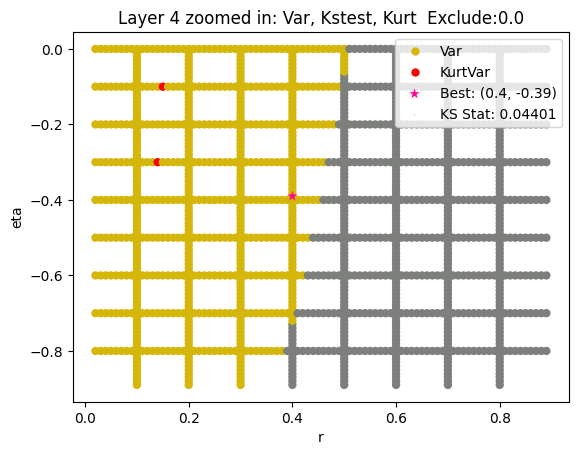

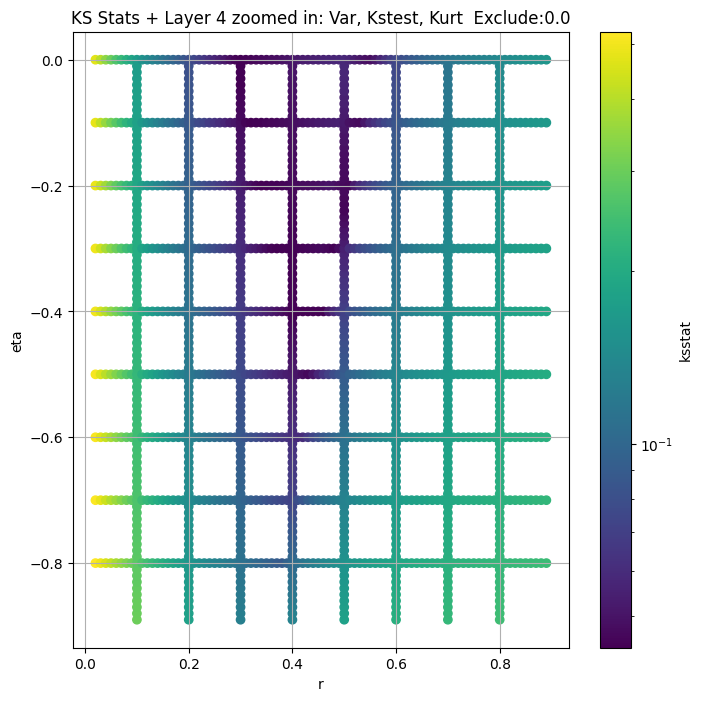

Layer 5


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.03425579719077726, var: 206867.859375


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.034269818094129656, var: 209486.375


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.034285092485878854, var: 212373.390625


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.03421277712560811, var: 215664.890625


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.034168669716801714, var: 220082.21875
Number of samples: 100000, Without approximation : 102656


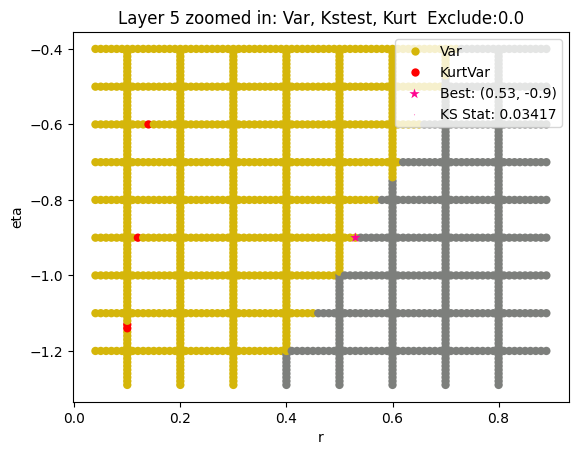

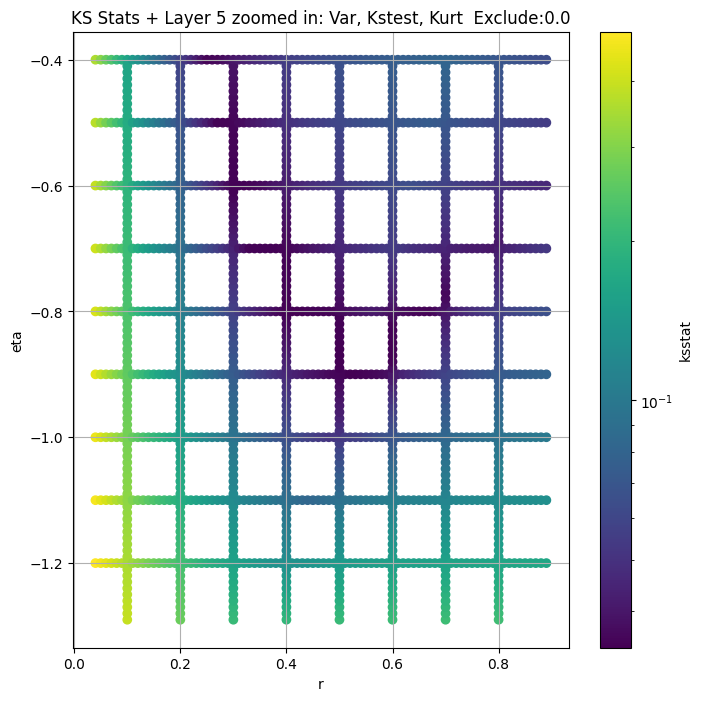

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 100 = 250, ksstat: 0.03200791763006211, var: 33548.546875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 75 = 225, ksstat: 0.03224103648652299, var: 33995.83984375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 50 = 200, ksstat: 0.032315360762383005, var: 34464.26953125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 25 = 175, ksstat: 0.032380133189255755, var: 34958.0546875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 0 = 150, ksstat: 0.03230010522882987, var: 35479.390625


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + -25 = 125, ksstat: 0.03233040077342991, var: 36033.1484375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + -50 = 100, ksstat: 0.03240482227963665, var: 36629.59765625


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + -75 = 75, ksstat: 0.032291108584837414, var: 37279.5859375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + -100 = 50, ksstat: 0.03237790897092896, var: 37997.359375
Number of samples: 100000, Without approximation : 410624


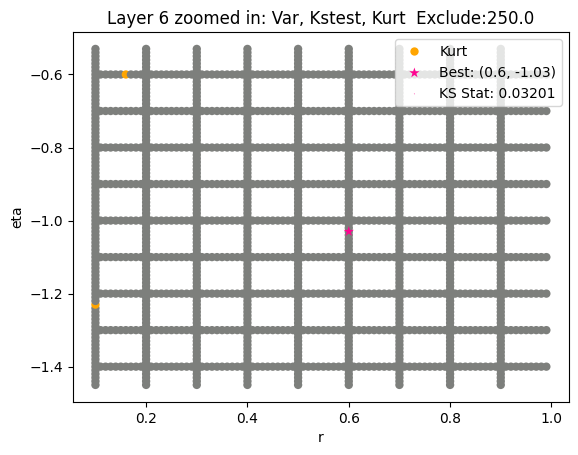

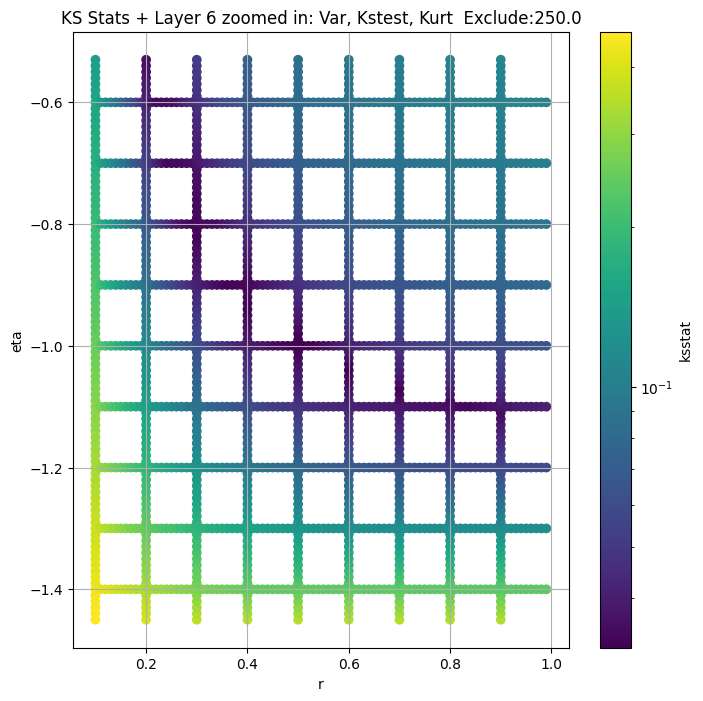

Layer 7


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 100 = 600, ksstat: 0.02900060569080426, var: 4567.5322265625


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 75 = 575, ksstat: 0.029251914464555773, var: 4623.61083984375


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 50 = 550, ksstat: 0.02976218880923881, var: 4681.40625


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 25 = 525, ksstat: 0.030193555582831655, var: 4740.94384765625


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + 0 = 500, ksstat: 0.030142902515428394, var: 4802.27392578125


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + -25 = 475, ksstat: 0.029931823144494163, var: 4865.54052734375


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + -50 = 450, ksstat: 0.029480081373029043, var: 4930.8857421875


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + -75 = 425, ksstat: 0.029020346435680966, var: 4998.4970703125


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 500.0 + -100 = 400, ksstat: 0.029452794780090774, var: 5068.4794921875
Number of samples: 100000, Without approximation : 1642496


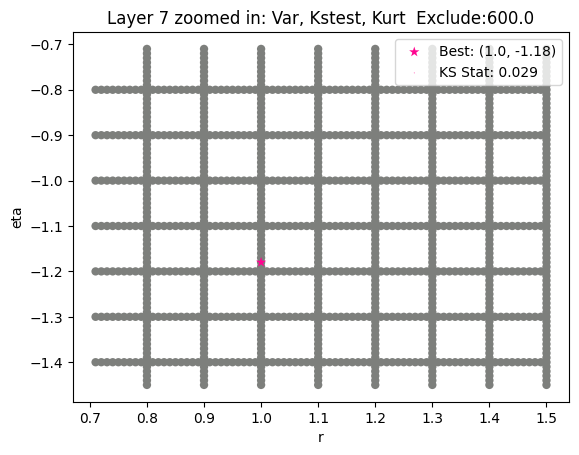

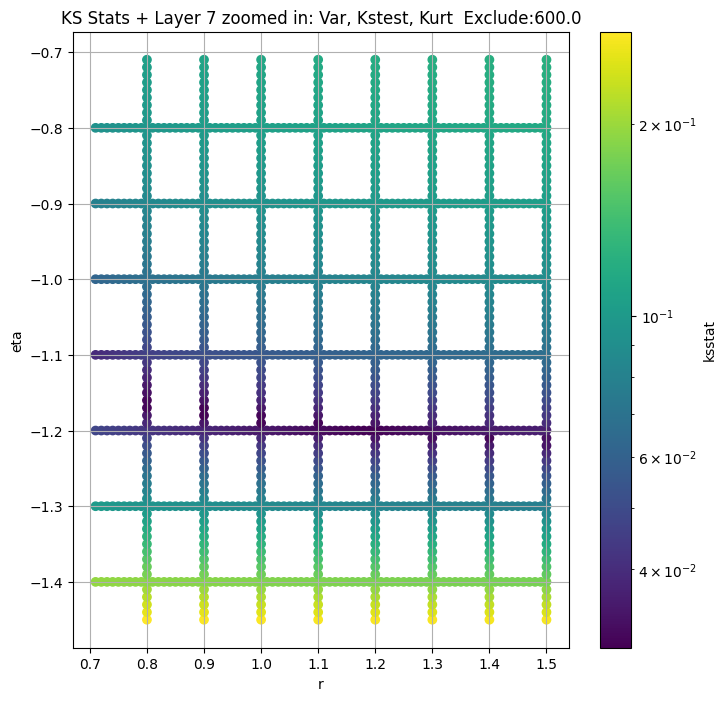

Layer 8


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + 100 = 350, ksstat: 0.0136936881830656, var: 886.4720458984375


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + 75 = 325, ksstat: 0.013438832565711933, var: 903.37060546875


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + 50 = 300, ksstat: 0.013745408182272267, var: 921.12353515625


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + 25 = 275, ksstat: 0.013831576607665985, var: 939.82666015625


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + 0 = 250, ksstat: 0.013255095561802044, var: 959.6043701171875


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + -25 = 225, ksstat: 0.013532530203350546, var: 980.5689086914062


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + -50 = 200, ksstat: 0.013820405832264626, var: 1002.9011840820312


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + -75 = 175, ksstat: 0.013272617161452782, var: 1026.7943115234375


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 250.0 + -100 = 150, ksstat: 0.013991309221893511, var: 1052.564208984375
Number of samples: 100000, Without approximation : 6569984


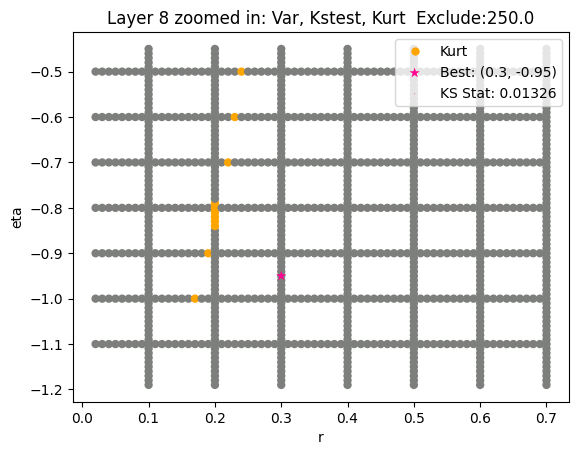

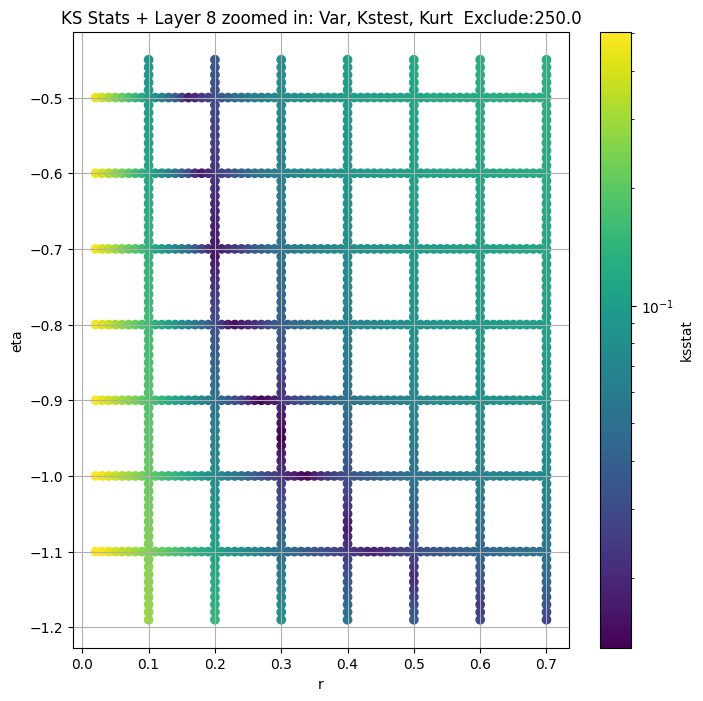

Layer 9


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.011157816907856166, var: 219.5291290283203


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.012275203380755828, var: 227.05018615722656


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.012055762267991377, var: 235.51597595214844


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.012408797208526723, var: 245.28773498535156


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.009869679497497397, var: 257.065185546875


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.009643801944265284, var: 274.0760803222656
Number of samples: 100000, Without approximation : 26279936


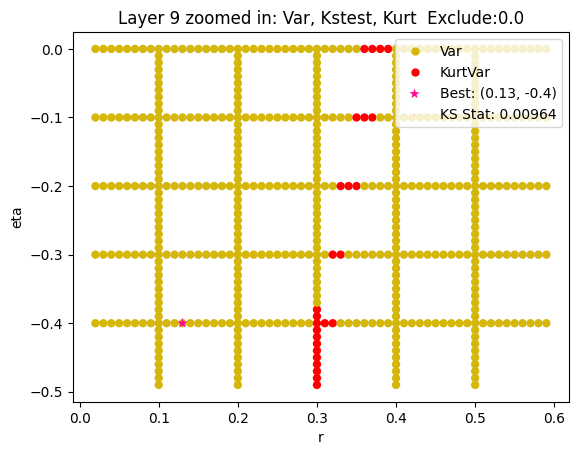

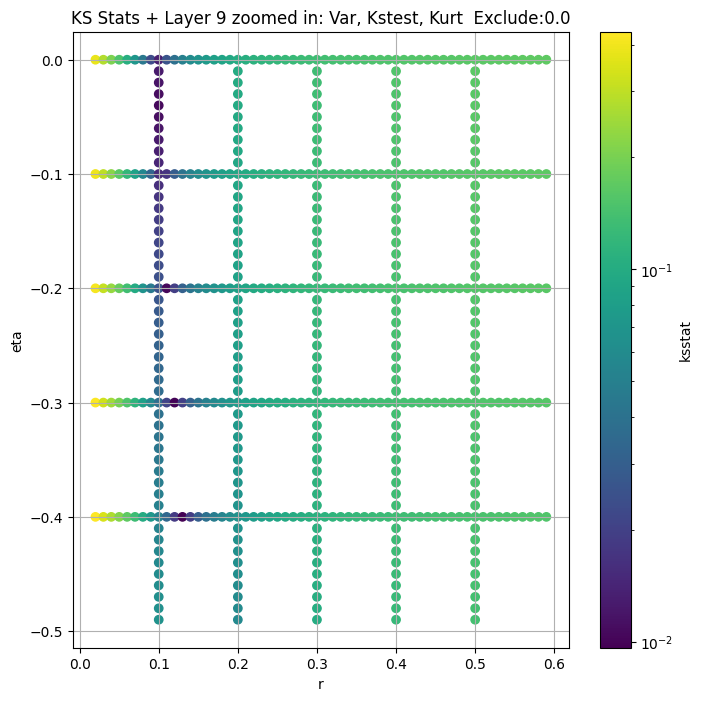

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.478996e+07  2.233421e+07  2.733704e+07   0.435762    0.032408   
3      5.422982e+06  5.098264e+06  5.754792e+06   1.545989    1.198762   
4      1.175513e+06  1.104955e+06  1.248217e+06   3.541689    2.922917   
5      2.200822e+05  2.051823e+05  2.355847e+05   5.292702    4.484963   
6      3.989627e+04  3.659656e+04  4.333954e+04   8.906837    7.516291   
7      6.966373e+03  6.281430e+03  7.704541e+03  13.543694   11.132702   
8      1.295555e+03  1.142669e+03  1.463124e+03  20.680162   16.469147   
9      2.740761e+02  2.375567e+02  3.139993e+02  27.580788   21.251253   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.899321           1604             0.100545        0.6         20.0   
3        1.921160           6416             0.059435        0.4          0.7   
4        4.230144          25664             0.044137        0.4         -0.4   
5        6.221855         102656             0.034375        0.4         -0.8   
6       10.530184         410624             0.032300        0.5         -1.0   
7       16.415705        1642496             0.030398        1.2         -1.2   
8       25.764788        6569984             0.015888        0.2         -0.7   
9       36.107666       26279936             0.011390        0.1          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       6.268102e+04                     0.0        2.478996e+07   
3       5.632023e+04                     0.0        5.422982e+06   
4       5.369387e+04                     0.0        1.175513e+06   
5       2.441367e+04                     0.0        2.200822e+05   
6       1.773970e+04                   150.0        3.354855e+04   
7       1.816908e+04                   500.0        4.567532e+03   
8       1.427983e-01                   250.0        9.596044e+02   
9       3.611985e-11                    25.0        2.740761e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.100426    0.63     20.00   
3                     0.016929          0.059423    0.38      0.80   
4                     0.008471          0.044011    0.40     -0.39   
5                     0.004237          0.034169    0.53     -0.90   
6                     0.002119          0.032008    0.60     -1.03   
7                     0.001060          0.029001    1.00     -1.18   
8                     0.000530          0.013255    0.30     -0.95   
9                     0.000265          0.009644    0.13     -0.40   

          best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                   
2       90140.021467                  0.0          189  
3       34515.031889                  0.0          505  
4       52711.982645                  0.0          901  
5      100000.000000                  0.0         1604  
6       30917.321062                250.0         1804  
7       14273.538208                600.0         2281  
8          29.172683                250.0        10827  
9           0.000002                  0.0        19248

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

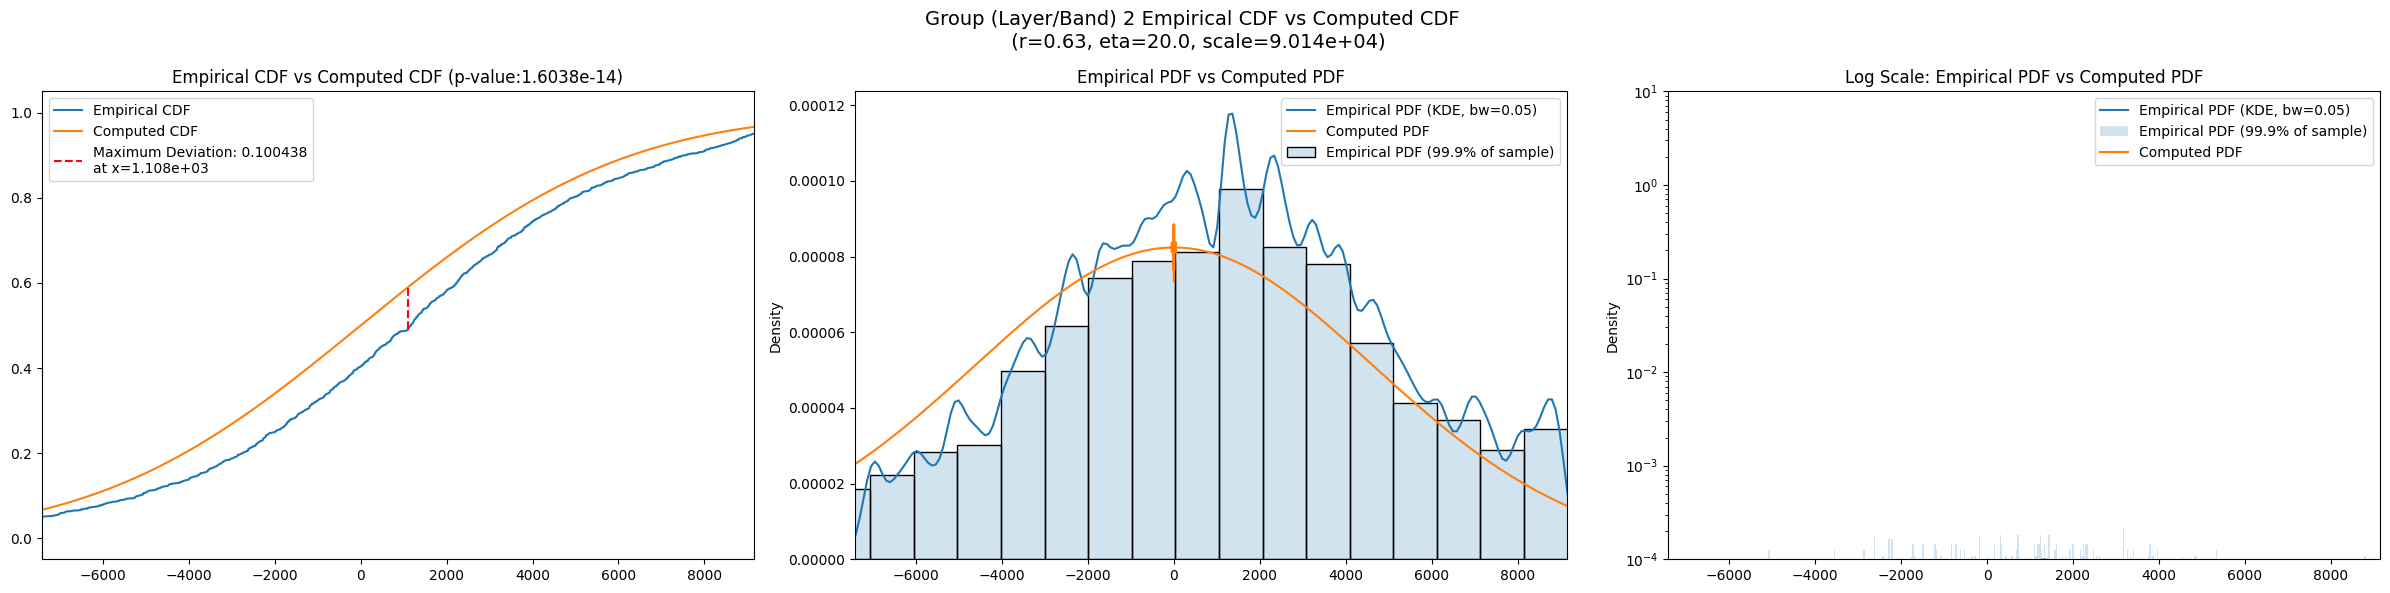

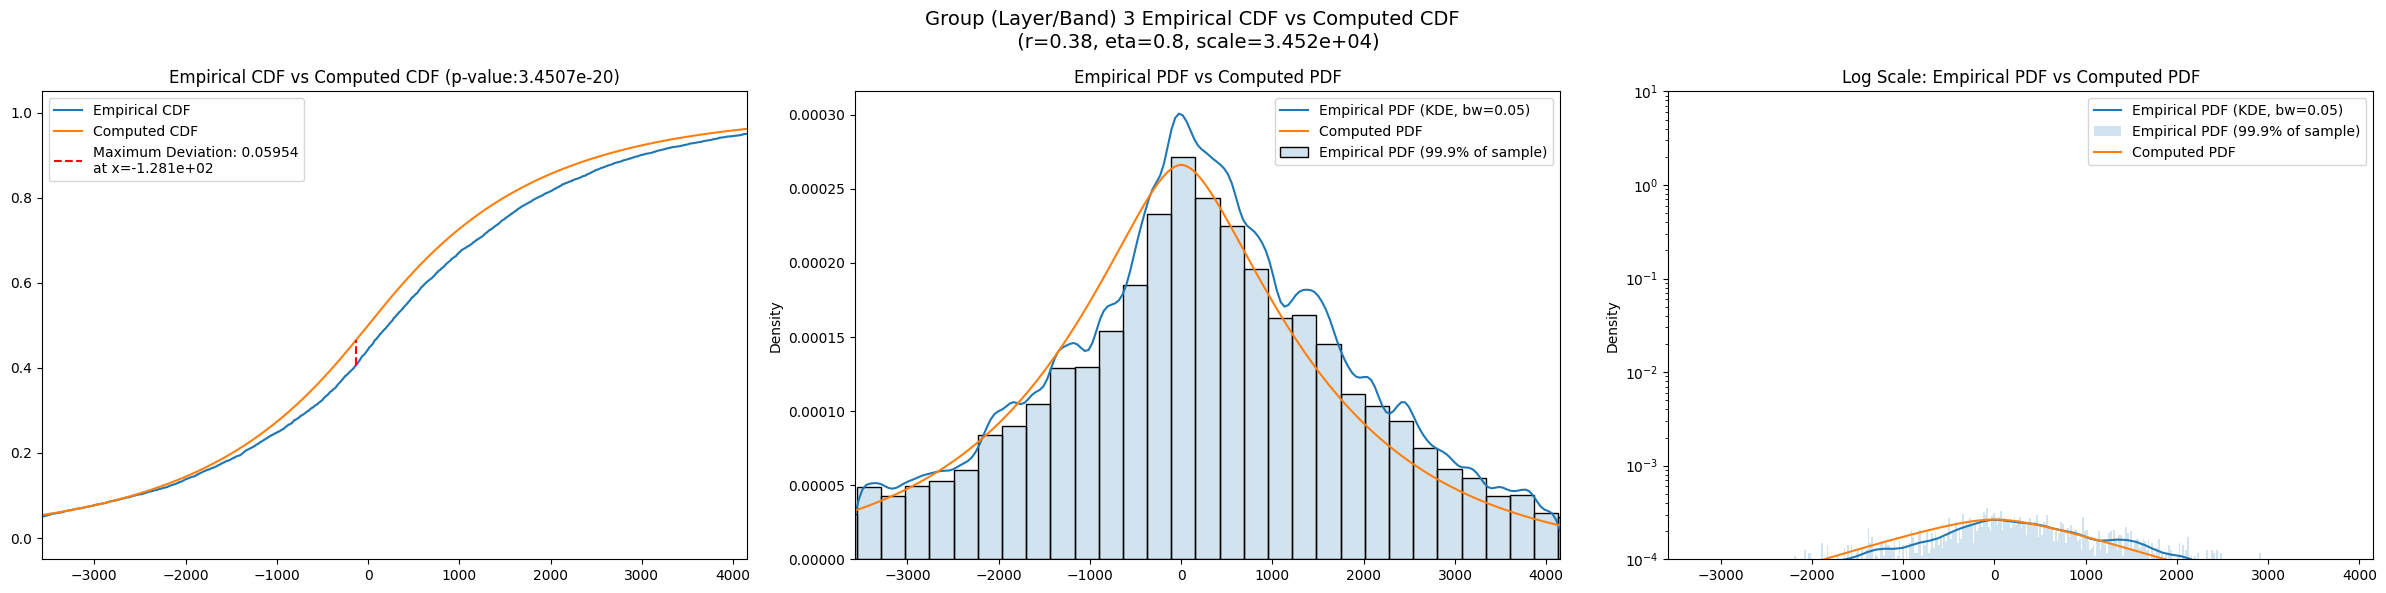

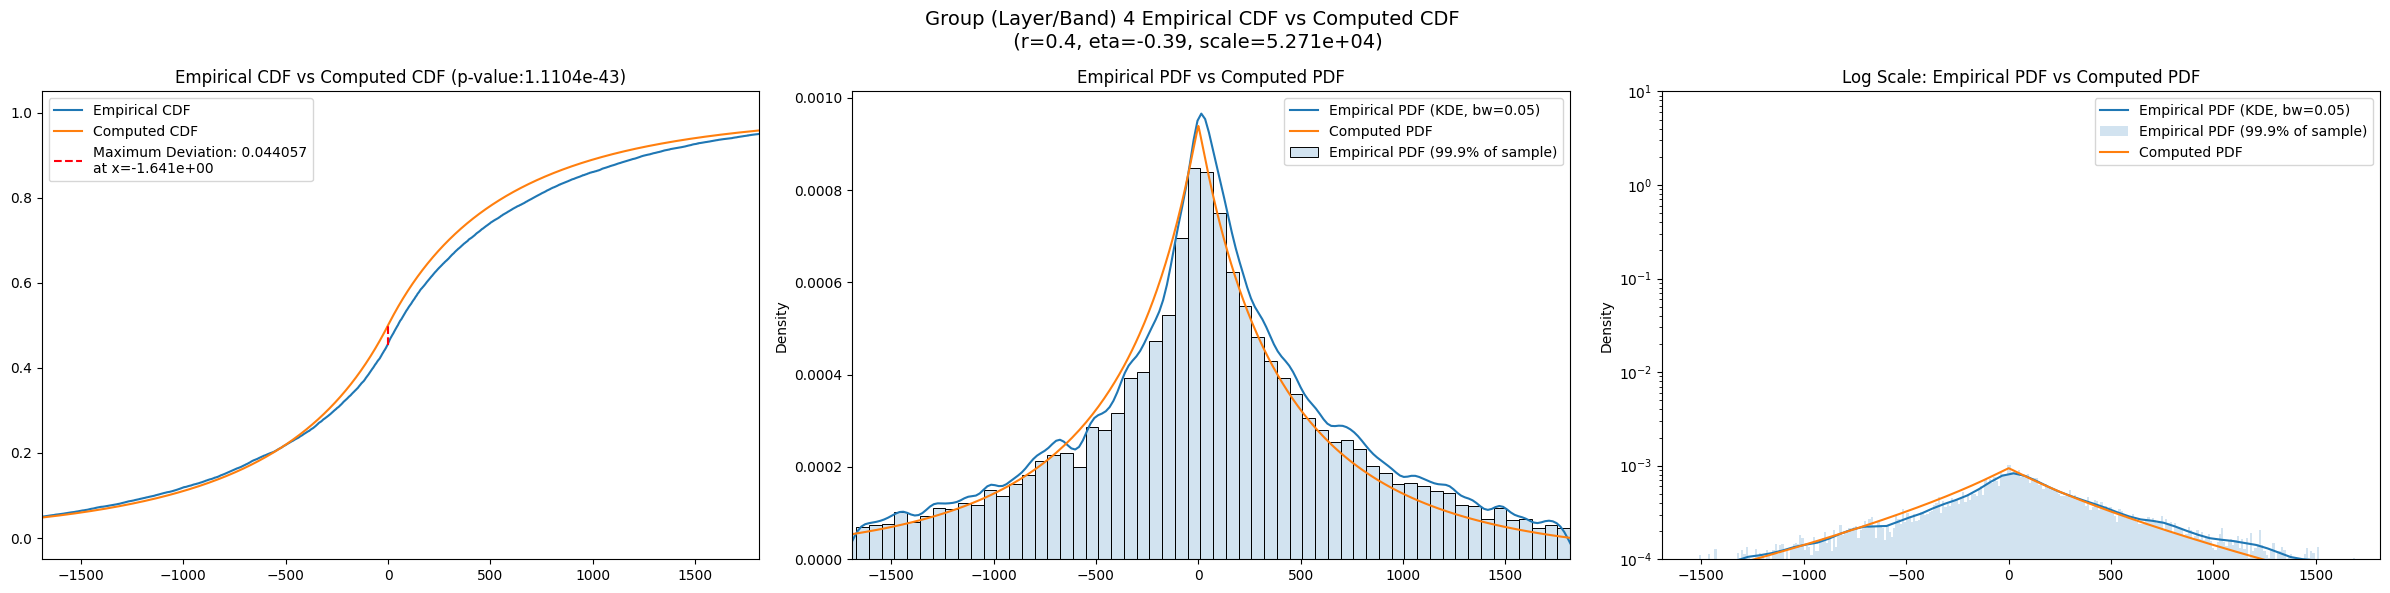

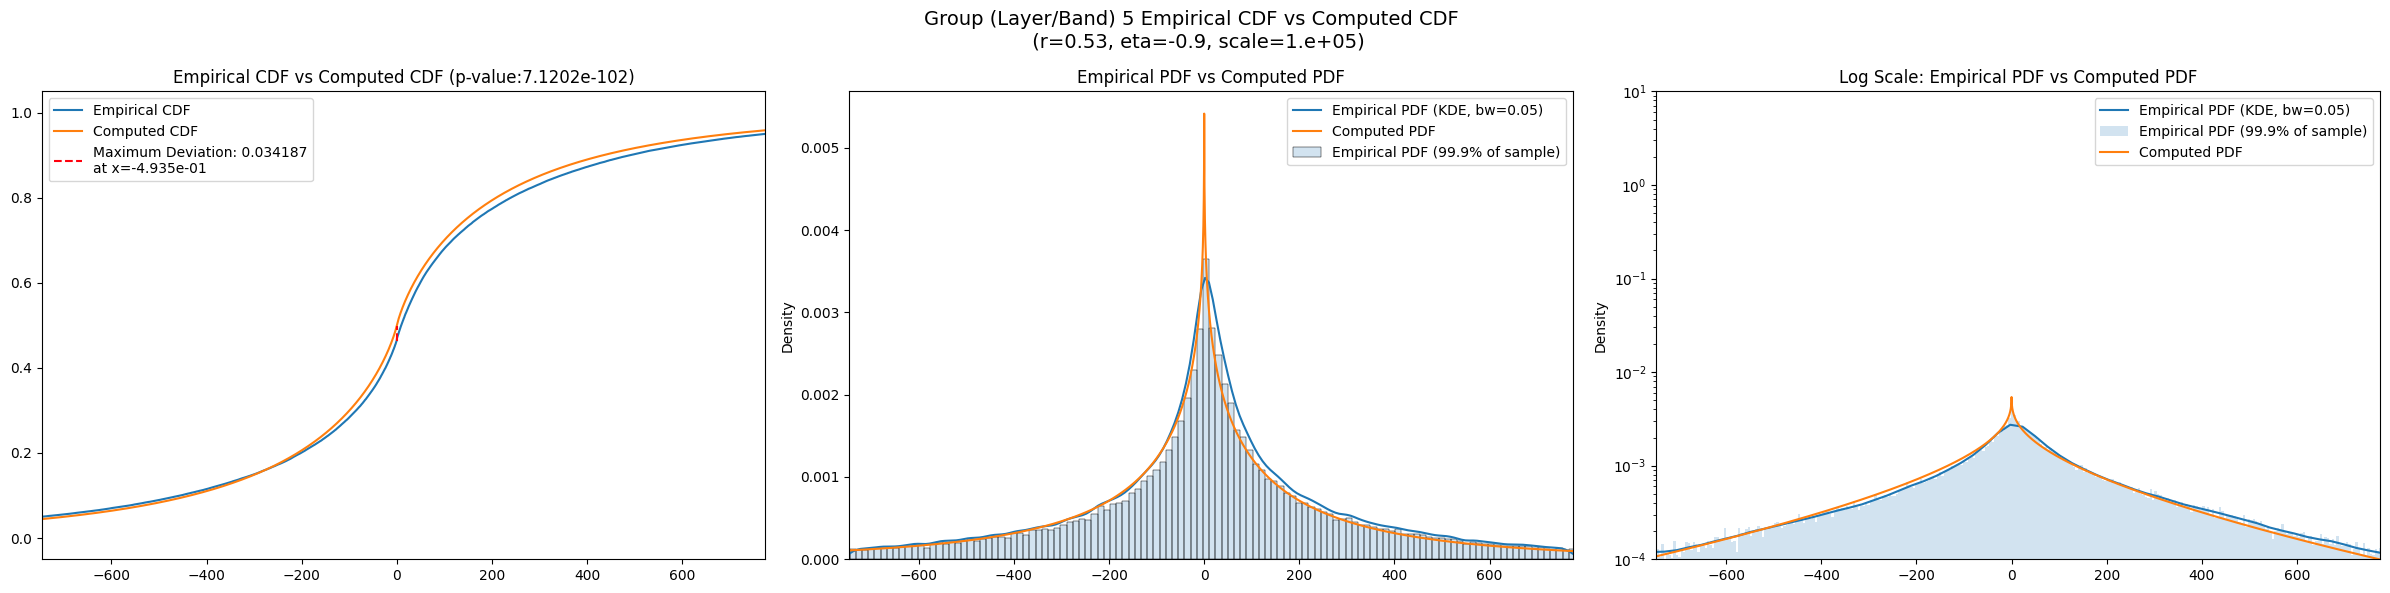

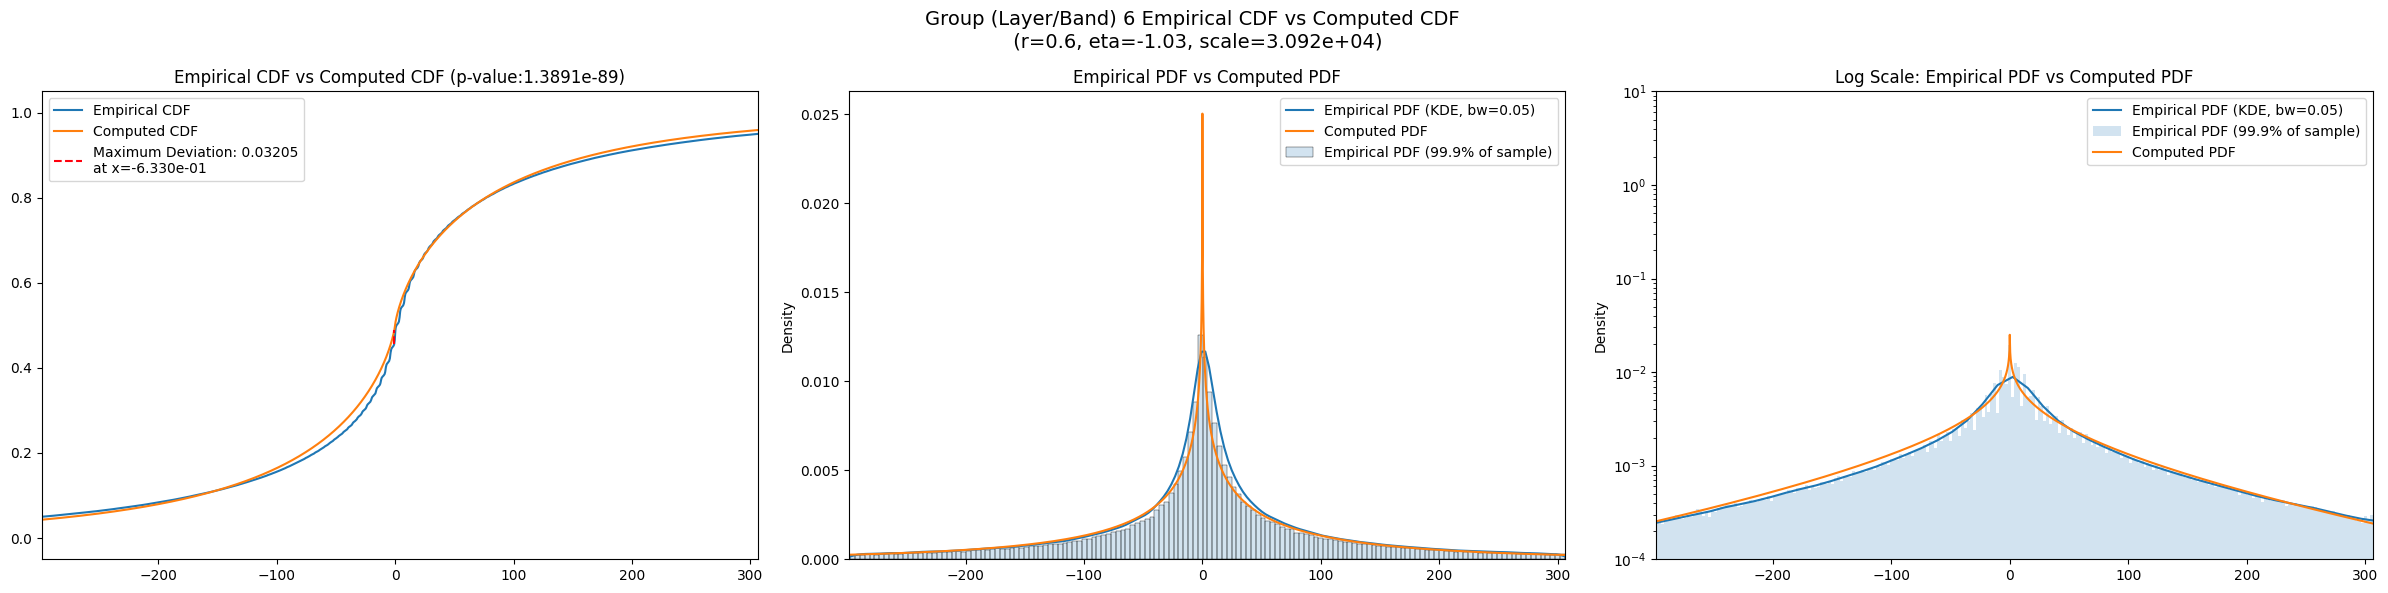

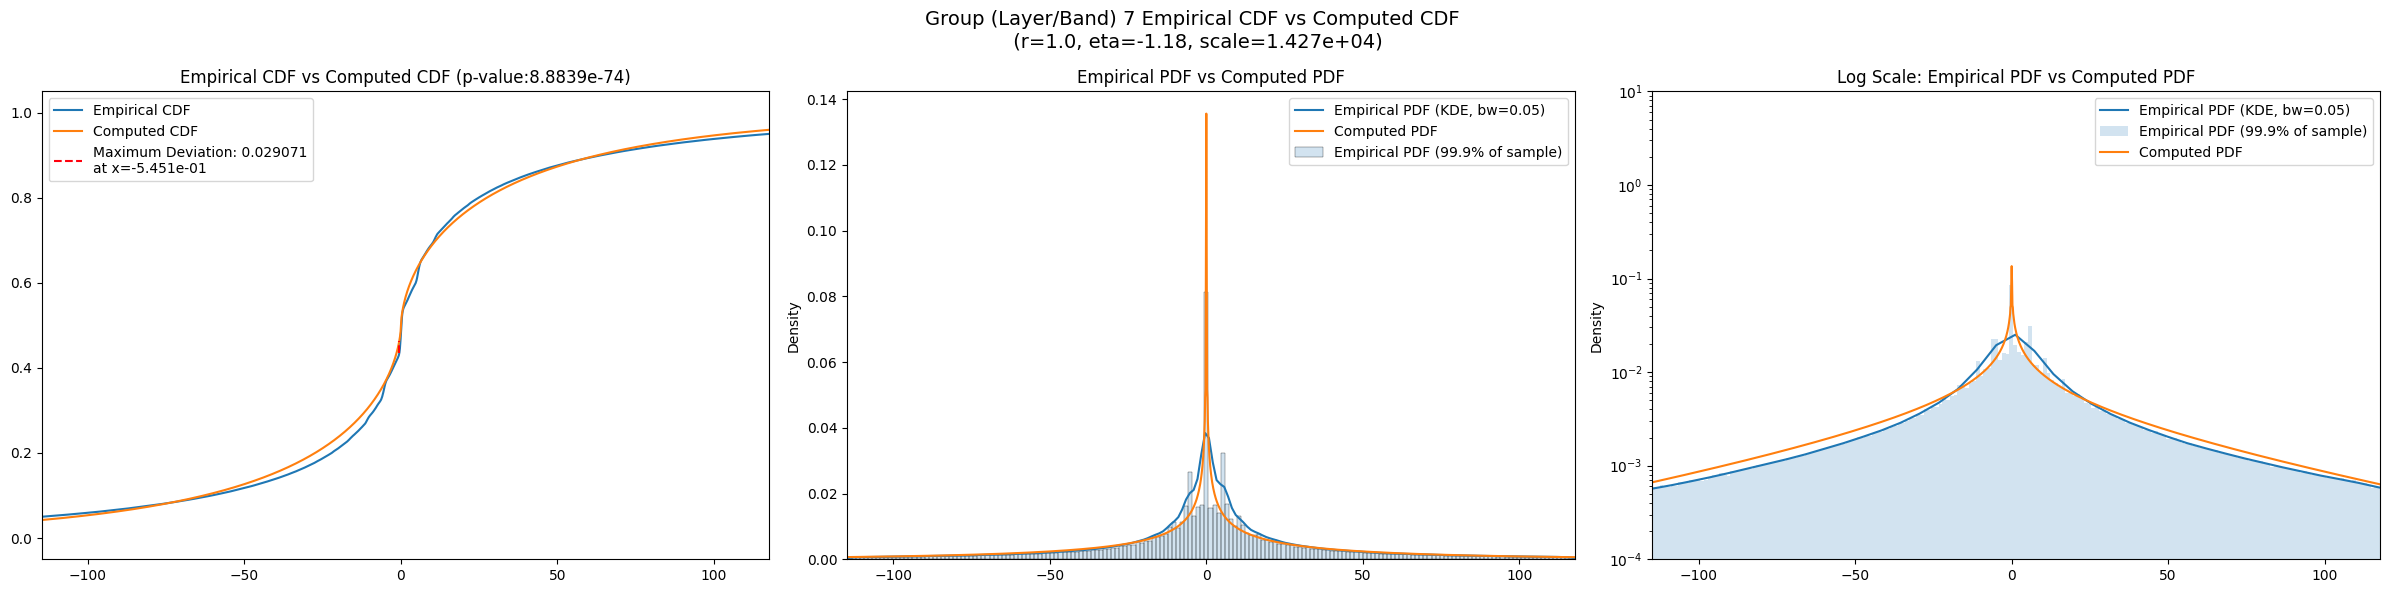

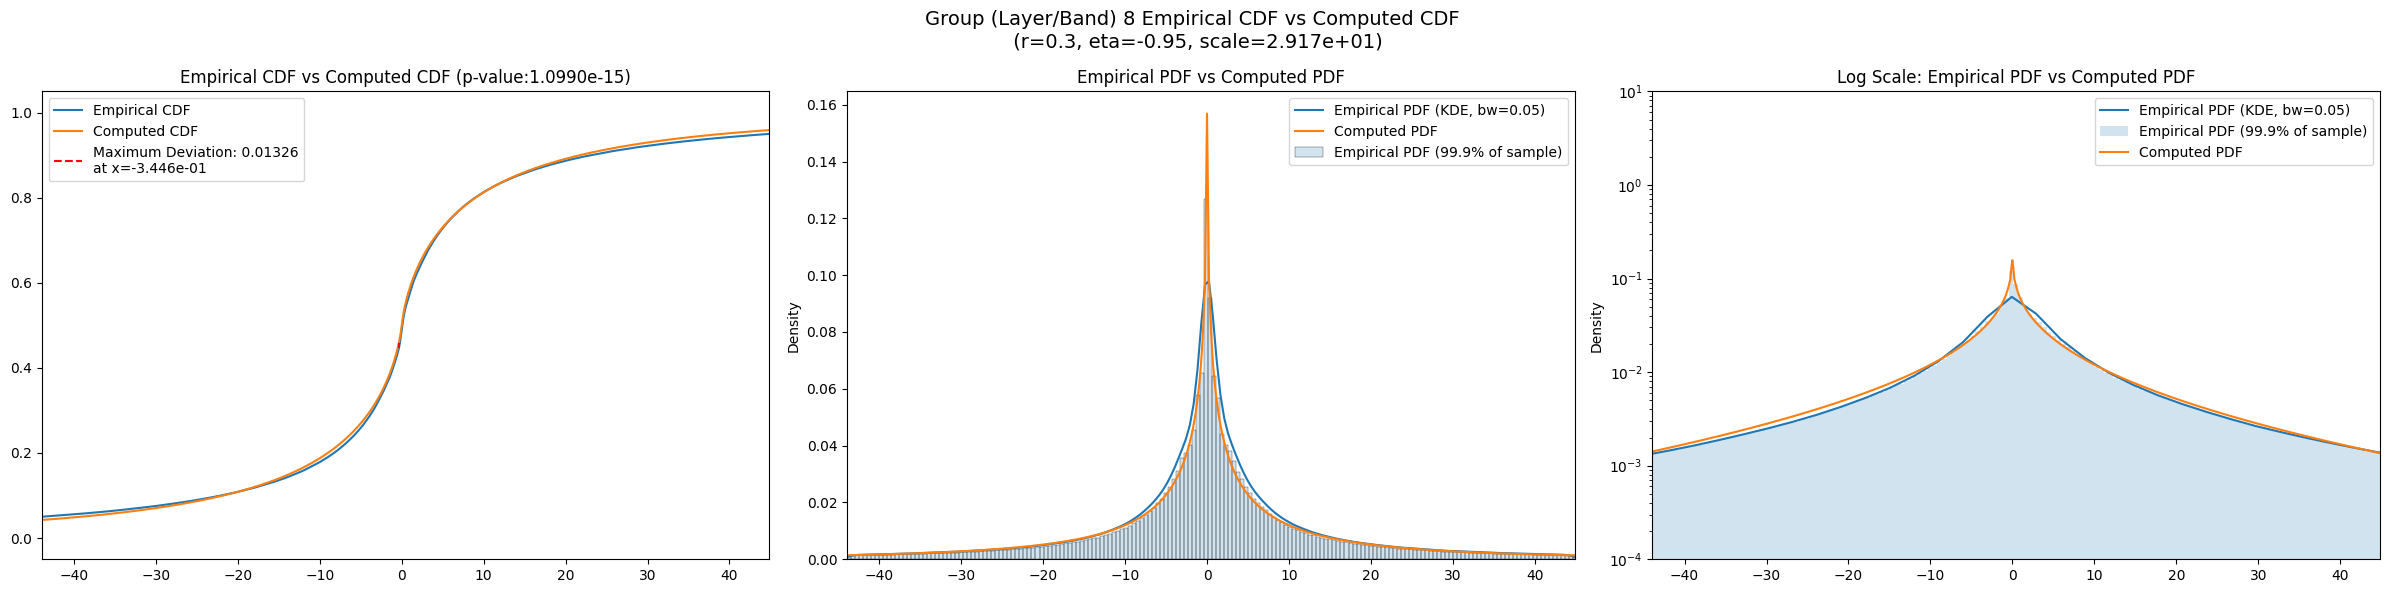

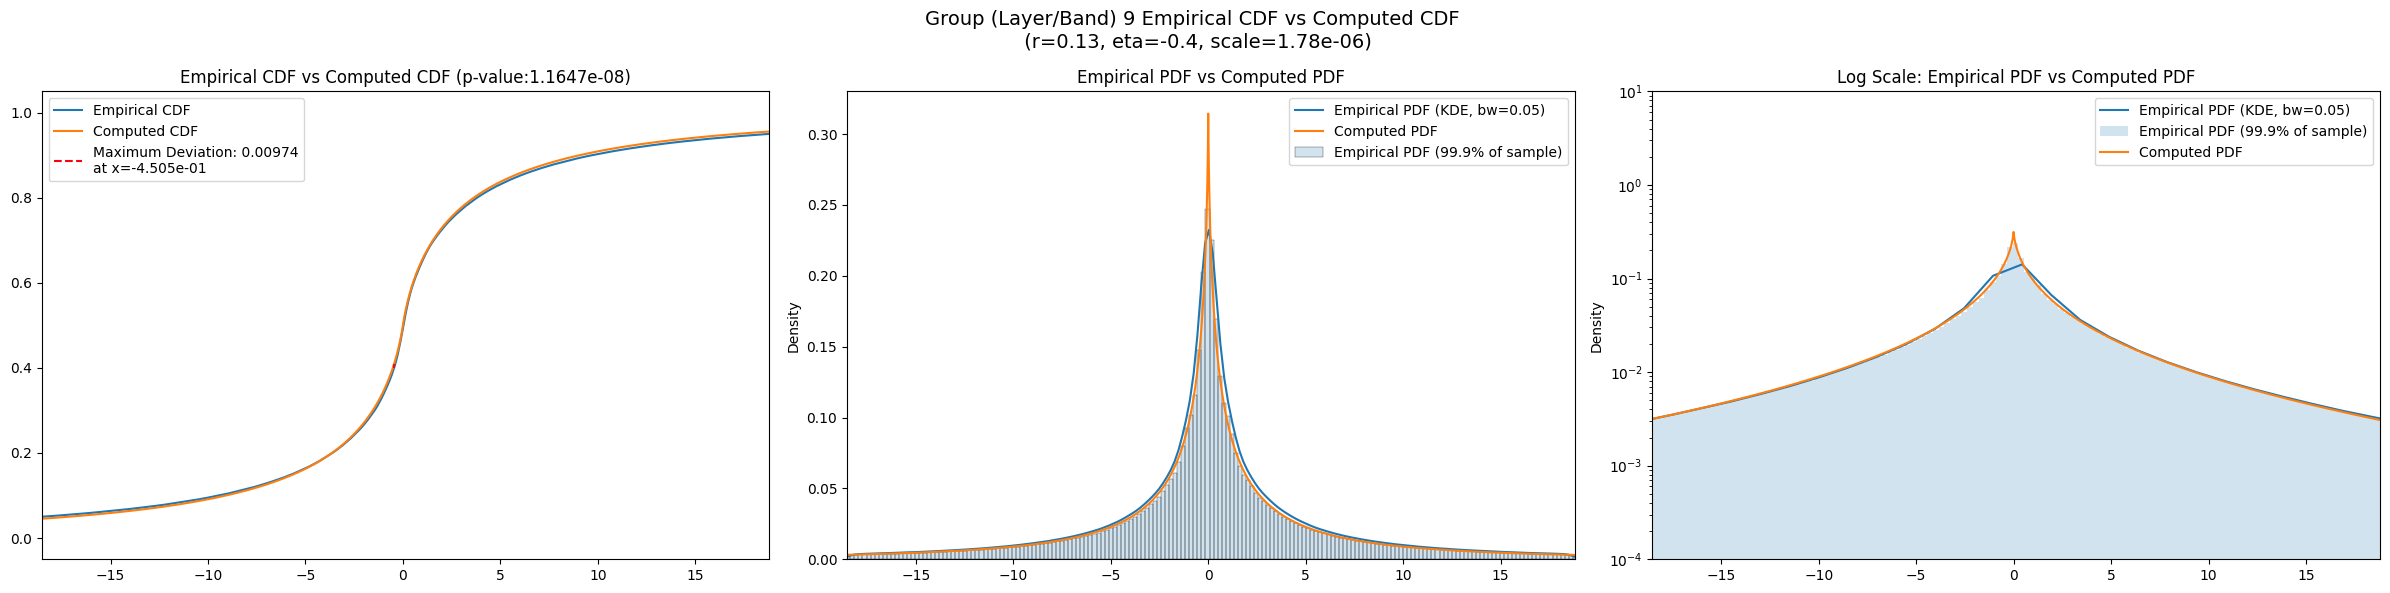

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.478996e+07  2.233421e+07  2.733704e+07   0.435762    0.032408   
3      5.422982e+06  5.098264e+06  5.754792e+06   1.545989    1.198762   
4      1.175513e+06  1.104955e+06  1.248217e+06   3.541689    2.922917   
5      2.200822e+05  2.051823e+05  2.355847e+05   5.292702    4.484963   
6      3.989627e+04  3.659656e+04  4.333954e+04   8.906837    7.516291   
7      6.966373e+03  6.281430e+03  7.704541e+03  13.543694   11.132702   
8      1.295555e+03  1.142669e+03  1.463124e+03  20.680162   16.469147   
9      2.740761e+02  2.375567e+02  3.139993e+02  27.580788   21.251253   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.899321           1604             0.100545        0.6         20.0   
3        1.921160           6416             0.059435        0.4          0.7   
4        4.230144          25664             0.044137        0.4         -0.4   
5        6.221855         102656             0.034375        0.4         -0.8   
6       10.530184         410624             0.032300        0.5         -1.0   
7       16.415705        1642496             0.030398        1.2         -1.2   
8       25.764788        6569984             0.015888        0.2         -0.7   
9       36.107666       26279936             0.011390        0.1          0.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      4895.47000              0.099501          2.818150e-14   
3      ...      1725.62000              0.064987          5.307900e-24   
4      ...       707.66600              0.064619          1.304290e-93   
5      ...       255.97600              0.072942          0.000000e+00   
6      ...        85.38170              0.083069          0.000000e+00   
7      ...        28.92330              0.087751          0.000000e+00   
8      ...        11.35590              0.079801          0.000000e+00   
9      ...         4.73271              0.080526          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         5407.20000             0.102644         3.631270e-15  4312.55000   
3         1786.02000             0.058778         1.037890e-19  1385.79000   
4          607.06400             0.045774         3.623980e-47   513.73900   
5          217.61300             0.048901        8.875950e-214   176.29800   
6           72.45020             0.058500         0.000000e+00    57.16330   
7           24.95240             0.062238         0.000000e+00    19.49490   
8            9.92517             0.054356         0.000000e+00     7.56190   
9            4.12959             0.054872         0.000000e+00     3.18181   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.099347   3.111880e-14          1.552726e-14  
3           0.060938   3.735940e-21          3.896503e-20  
4           0.050562   1.848700e-57          1.237212e-43  
5           0.053681  1.494570e-257         1.456670e-104  
6           0.061287   0.000000e+00          0.000000e+00  
7           0.062386   0.000000e+00          0.000000e+00  
8           0.054678   0.000000e+00          0.000000e+00  
9           0.054851   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.100545                 0.033804          0.100426   
3                 0.059435                 0.016929          0.059423   
4                 0.044137                 0.008471          0.044011   
5                 0.034375                 0.004237          0.034169   
6                 0.032300                 0.002119          0.032008   
7                 0.030398                 0.001060          0.029001   
8                 0.015888                 0.000530          0.013255   
9                 0.011390                 0.000265          0.009644   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.099501             0.102644       0.099347  
3                  0.064987             0.058778       0.060938  
4                  0.064619             0.045774       0.050562  
5                  0.072942             0.048901       0.053681  
6                  0.083069             0.058500       0.061287  
7                  0.087751             0.062238       0.062386  
8                  0.079801             0.054356       0.054678  
9                  0.080526             0.054872       0.054851

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
layer                                                                          
2            2.478996e+07          0.100426    0.63     20.00   90140.021467   
3            5.422982e+06          0.059423    0.38      0.80   34515.031889   
4            1.175513e+06          0.044011    0.40     -0.39   52711.982645   
5            2.200822e+05          0.034169    0.53     -0.90  100000.000000   
6            3.354855e+04          0.032008    0.60     -1.03   30917.321062   
7            4.567532e+03          0.029001    1.00     -1.18   14273.538208   
8            9.596044e+02          0.013255    0.30     -0.95      29.172683   
9            2.740761e+02          0.009644    0.13     -0.40       0.000002   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    250.0  
7                    600.0  
8                    250.0  
9                      0.0

In [21]:
eng.quit()